In [15]:
import geopandas as gp
import pandas as pd
import os
import glob
import openpyxl
import matplotlib.pyplot as plt
import plotly.express as px #if using plotly

In [16]:
us_states = gp.read_file("data/s_22mr22.shp")
ca_state = gp.read_file("/Users/natebender/Desktop/repo/capstone_rmi/data/CA_State_TIGER2016.shp")
ca_counties = gp.read_file("/Users/natebender/Desktop/repo/capstone_rmi/data/CA_Counties_TIGER2016.shp")

In [17]:
# type of production: flaring, supply chain: upstream, year: 2021
flare_up_21 = pd.read_excel("/Users/natebender/Desktop/repo/capstone_rmi/data/VIIRS_Global_flaring_d.7_slope_0.029353_2021_web (2).xlsx",
             sheet_name="flare upstream")

In [18]:
#syntax: df.loc[df['col1'] == value]

flare_up_21 = flare_up_21.loc[flare_up_21["ISO Code"] == "USA"]  # subset to just USA

In [19]:
# Convert lat/long to points in geodataframe
flare_up_21 = gp.GeoDataFrame(
    flare_up_21, geometry=gp.points_from_xy(flare_up_21["Longitude"], flare_up_21["Latitude"]), crs = us_states.crs)

/Users/natebender/opt/anaconda3/envs/capstonermi37/lib/python3.7/site-packages/geopandas/array.py:275: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.



In [20]:
flare_up_21.head(2)

,Country,ISO Code,Catalog ID,ID 2021,Latitude,Longitude,BCM 2021,"Avg. temp., K",Ellipticity,Detection frequency 2021,Clear Obs.,Type,geometry
544,United States,USA,USA_UPS_2015_102.6995W_47.8441N_v0.2,920,47.844061,-102.699454,0.057693,1863.62,1.94222,73.3553,304,upstream oil,POINT (-102.69945 47.84406)
552,United States,USA,USA_UPS_2015_101.7772W_31.3639N_v0.2,2523,31.363923,-101.777235,0.056710,1755.06,3.90138,83.4337,332,upstream oil,POINT (-101.77724 31.36392)


In [21]:
# drop orig lat/long cols. They're unnecessary now w geodataframe
flare_up_21.drop(['Latitude', 'Longitude'], axis=1, inplace=True)  

In [22]:
# create new column of state names via spatial join with the us_states polygons
joined = gp.sjoin(flare_up_21, us_states, how = 'left', op = 'within')  

In [23]:
#syntax df.rename(columns = {'oldname':'newname'}, inplace = True)

joined.drop(['NAME', 'FIPS', 'LON', 'LAT', "index_right"], axis=1, inplace=True)  # drop extra cols created by spatial join
joined.rename(columns = {'STATE':'State'}, inplace = True)  # make consistent col names
ca_joined = joined.loc[joined["State"] == "CA"]  # subset to just CA
ak_lower48 = joined.loc[joined["State"] != ["CA", ]  # subset to just CA

['ND',
 'TX',
 'NM',
 'AK',
 nan,
 'IL',
 'MS',
 'CA',
 'MT',
 'MI',
 'UT',
 'WY',
 'LA',
 'OK',
 'CO',
 'NV',
 'TN',
 'WV',
 'AL',
 'OH',
 'MD',
 'SD',
 'KS',
 'AR',
 'KY',
 'FL',
 'AZ']

In [38]:
us_states = us_states[us_states['STATE'].isin(['ND',
 'TX',
 'NM',
 'AK',
 'IL',
 'MS',
 'CA',
 'MT',
 'MI',
 'UT',
 'WY',
 'LA',
 'OK',
 'CO',
 'NV',
 'TN',
 'WV',
 'AL',
 'OH',
 'MD',
 'SD',
 'KS',
 'AR',
 'KY',
 'FL',
 'AZ'])]

### Testing plots

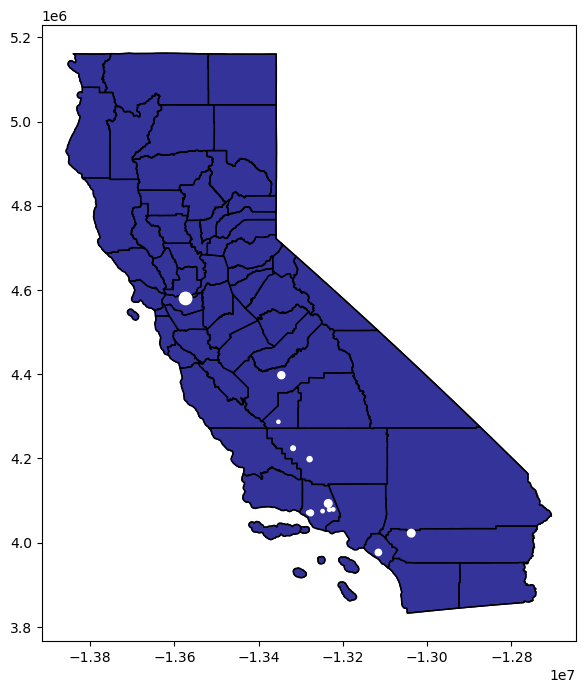

In [11]:
# # Plotting multiple layers
fig, ax = plt.subplots(figsize = (10,8))
ca_state.plot(ax = ax, cmap = 'terrain', edgecolor = 'black')
ca_counties.plot(ax = ax, color = 'none', edgecolor = 'black')
ca_joined.to_crs(epsg=3857).plot(ax = ax, color='white', markersize=joined['BCM 2021']*10000)  # increase size for visibility
plt.show()

In [28]:
joined

,Country,ISO Code,Catalog ID,ID 2021,BCM 2021,"Avg. temp., K",Ellipticity,Detection frequency 2021,Clear Obs.,Type,geometry,State
544,United States,USA,USA_UPS_2015_102.6995W_47.8441N_v0.2,920,0.057693,1863.62,1.94222,73.3553,304,upstream oil,POINT (-102.69945 47.84406),ND
552,United States,USA,USA_UPS_2015_101.7772W_31.3639N_v0.2,2523,0.056710,1755.06,3.90138,83.4337,332,upstream oil,POINT (-101.77724 31.36392),TX
582,United States,USA,USA_UPS_2021_101.7477W_32.2900N_v0.2,2540,0.054425,1838.83,1.93303,53.2110,327,upstream oil,POINT (-101.74770 32.28997),TX
632,United States,USA,USA_UPS_2015_101.9307W_32.1538N_v0.2,2434,0.049698,1785.26,2.28476,52.6786,336,upstream oil,POINT (-101.93074 32.15381),TX
658,United States,USA,USA_UPS_2021_103.3577W_32.1836N_v0.2,1972,0.047155,1855.15,1.66581,57.9937,319,upstream oil,POINT (-103.35773 32.18362),NM
...,...,...,...,...,...,...,...,...,...,...,...,...
9334,United States,USA,USA_UPS_2018_101.9666W_31.8794N_v0.2,2416,0.000000,1820.18,1.60150,0.0000,343,upstream oil,POINT (-101.96663 31.87944),TX
9339,United States,USA,USA_UPS_2017_97.3424W_29.3615N_v0.2,3362,0.000000,1906.80,1.60150,0.0000,294,upstream oil,POINT (-97.34243 29.36146),TX
9350,United States,USA,USA_UPS_2017_97.4591W_29.2178N_v0.2,3338,0.000000,1847.24,1.60150,0.0000,310,upstream oil,POINT (-97.45911 29.21783),TX
9351,United States,USA,USA_UPS_2020_101.8663W_31.4039N_v0.2,2466,0.000000,1977.14,1.60150,0.0000,345,upstream oil,POINT (-101.86626 31.40386),TX


In [41]:
list(joined["State"].unique())  # find unique values of states with production
us_states = us_states[us_states['STATE'].isin(['ND',
 'TX',
 'NM',
 'AK',
 'IL',
 'MS',
 'CA',
 'MT',
 'MI',
 'UT',
 'WY',
 'LA',
 'OK',
 'CO',
 'NV',
 'TN',
 'WV',
 'AL',
 'OH',
 'MD',
 'SD',
 'KS',
 'AR',
 'KY',
 'FL',
 'AZ'])]

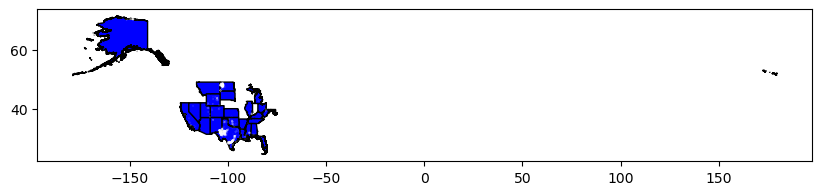

In [42]:
# # Plotting multiple layers
fig, ax = plt.subplots(figsize = (10,8))
us_states.plot(ax = ax, color = 'blue', edgecolor = 'black')
joined.plot(ax = ax, color='white', markersize=joined['BCM 2021'])  # increase size for visibility
plt.show()